<a href="https://colab.research.google.com/github/gregorywmorris/MLZoom2022/blob/main/midterm/notebook.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
#@title Auto-save / Auto-reload
%autosave 1

%load_ext autoreload
%autoreload 2

Autosaving every 1 seconds


# !pip

In [ ]:
!pip install catboost

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scikit-plot

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install scipy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install dask==2022.02.0

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dask-2022.2.0-py3-none-any.whl (1.1 MB)
  Attempting uninstall: dask
    Found existing installation: dask 2021.12.0
    Uninstalling dask-2021.12.0:
      Successfully uninstalled dask-2021.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
dataprep 0.4.3 requires dask[array,dataframe,delayed]<2022.0,>=2021.11, but you have dask 2022.2.0 which is incompatible.


In [ ]:
!pip install dataprep

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Using cached dask-2021.12.0-py3-none-any.whl (1.0 MB)
  Attempting uninstall: dask
    Found existing installation: dask 2022.2.0
    Uninstalling dask-2022.2.0:
      Successfully uninstalled dask-2022.2.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
distributed 2022.2.0 requires dask==2022.02.0, but you have dask 2021.12.0 which is incompatible.


# Imports

In [ ]:
# for EDA
import pylab
import pandas as pd
import numpy as np
import scipy.stats as stats
from scipy.stats import ttest_ind
import scipy
import scipy.sparse as sparse 
from scipy.sparse import csr_matrix
import scipy.sparse.linalg as sla# needed for dataprep
from dataprep.eda import create_report


# visualization
import seaborn as sns
import matplotlib.pyplot as plt
import scikitplot as skplt # https://scikit-plot.readthedocs.io/en/stable/Quickstart.htm
from IPython.display import display

# models
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.impute import KNNImputer
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from sklearn.naive_bayes import ComplementNB

# tuning and metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, classification_report, roc_curve, precision_recall_curve, auc, confusion_matrix, roc_auc_score
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFECV
from sklearn.feature_selection import RFE
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mutual_info_score

# still need?
from sklearn.metrics import mean_squared_error as rmse
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score


# Project Deliverables

**For a project, you repository/folder should contain the following:**

* `README.md` with
  * Description of the problem
  * Instructions on how to run the project
* Data
  * You should either commit the dataset you used or have clear instructions how to download the dataset
* Notebook (suggested name - `notebook.ipynb`) with
  * Data preparation and data clearning
  * EDA, feature importance analysis
  * Model selection process and parameter tuning
* Script train.py (suggested name)
  * Training the final model
  * Saving it to a file (e.g. pickle) or saving it with specialized software (BentoML)
* Script `predict.py` (suggested name)
  * Loading the model
  * Serving it via a web serice (with Flask or specialized sofware - BentoML, KServe, etc)
* Files with dependencies
  * `Pipenv` and `Pipenv.lock` if you use Pipenv
  * `bentofile.yaml` if you use BentoML
  * or equivalents: conda environment file, requirements.txt or pyproject.toml
* `Dockerfile` for running the service
* Deployment
  * URL to the service you deployed or
  * Video or image of how you interact with the deployed service





# Notebook Index

* [Problem Statement](#problem)
* [Data Selection](#data_about)
  * [Data Extraction](#extraction)
* [Data prep, clean, and EDA](#init_eda)
* [Model Baseline](#baseline)
* [Tuning](#tuning)
  * [Feature Importance](#feat_imp)
* [Deployment](#deploy)

<a name="problem"></a>
# Why Predicting Stroke Likelihood Matters





### By the Numbers
**Global**

Strokes are a global epidemic. They are the second leading cause of death and have increased by 70% between 1990 to 2019, with death from strokes inceasing by 43% ([source](https://www.thelancet.com/journals/laneur/article/PIIS1474-4422(21)00252-0/fulltext)). The WHO estimates the anual cost of strokes to be over US$721 billion ([source](https://pubmed.ncbi.nlm.nih.gov/34986727/#:~:text=Abstract,%25%20of%20the%20global%20GDP)).

**United States**

While strokes have been declining for decades in the US, it still has a large financial burden, amounting to $53 billion anually ([source](https://www.cdc.gov/stroke/facts.htm)). Currently stroke is the 5th leading cause of death in the US ([source](https://www.cdc.gov/nchs/fastats/leading-causes-of-death.htm)).

### Optimal Outcomes
**Global**

Predicting stroke can provide an opportunity to take corrective actions before a stroke occurs. Most importantly, resulting in fewer deaths and disabilities.

Addtionally, the money lost to strokes would boost econamies. Assuming cost and stroke occurance are linear, if strokes were reduced by just 5%, that would inject $36 billion into world economies.

**United States**

And $2.65 billion into the US econamy.

<a name="about_data"></a>
# Stroke Data

### An Appropriate Dataset
A seach for various stroke datasets that included health factors showed that the [Kaggle dataset](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) was best suited. Numerous other stroke datasets are avaialbe but the lacked health factors needed. Datasets were often location based or even post stroke images. Neither are well suited for the the desired task.

### Limitations

* It is known that there are more factors for stroke prediction (such as [lab tests](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8686476/), lifestyle, etc.) than are avaialble in this data set.
  * However, [the most important factors](https://www.sciencedirect.com/science/article/pii/S2772442522000090) are in the dataset
* This data set was uploaded 2 years ago with no expectations of being updated.
* The source and accuracy to the data is unkown, a verified healthcare organization would be an ideal source for stroke data.

# Extract-Load-Transform (ELT)

#### The Process


**Extract:** Data is extracted from [Kaggle](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset) to [GitHub](https://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csvhttps://github.com/gregorywmorris/MLZoom2022/blob/main/midterm/healthcare-dataset-stroke-data.csv)

**Load:** Data is loaded to the notebook

**Transform:** Data is modified to suit and improve the model

<a name="extraction"></a>
### Load

In [ ]:
data = 'https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv'

In [ ]:
!wget $data -O data.csv

--2022-11-03 22:19:22--  https://raw.githubusercontent.com/gregorywmorris/MLZoom2022/main/midterm/healthcare-dataset-stroke-data.csv
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 316971 (310K) [text/plain]
Saving to: ‘data.csv’

data.csv            100%[===================>] 309.54K  --.-KB/s    in 0.009s  

2022-11-03 22:19:22 (34.8 MB/s) - ‘data.csv’ saved [316971/316971]



In [ ]:
df = pd.read_csv('data.csv')

<a name="init_eda"></a>
### Transform - Exploritory Data Analysis (EDA)

##### [Dataprep](https://docs.dataprep.ai/user_guide/clean/introduction.html)

DataPrep Report
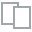
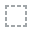
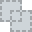
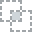
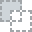
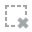
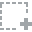
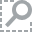
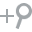
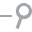
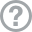
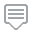
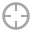
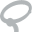
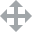
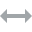
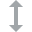
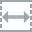
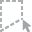
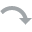
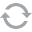
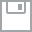
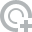
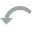
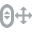
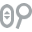
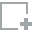
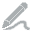
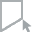
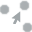
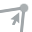
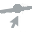

In [ ]:
create_report(df)

**Report Summary:**
* bmi has 201 missing values
* No zero values (except where binary)
* Feature distributions are skewed
* Mix of numerical and catigorical features
* Low feature correlation

##### **Overview**

In [ ]:
df.head(3)

,id,gender,age,hypertension,heart_disease,ever_married,work_type,Residence_type,avg_glucose_level,bmi,smoking_status,stroke
0,9046,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1
1,51676,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,NaN,never smoked,1
2,31112,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1


In [ ]:
#@title Drop column 'id'
df = df.drop(columns='id')

In [ ]:
#@title Column names are need to be normalized to all lower case
col = df.columns.tolist() # list with new column names all lower case
df = df.rename(str.lower, axis='columns')

In [ ]:
#@title data Overview
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5110 entries, 0 to 5109
Data columns (total 11 columns):
 #   Column             Non-Null Count  Dtype  
---  ------             --------------  -----  
 0   gender             5110 non-null   object 
 1   age                5110 non-null   float64
 2   hypertension       5110 non-null   int64  
 3   heart_disease      5110 non-null   int64  
 4   ever_married       5110 non-null   object 
 5   work_type          5110 non-null   object 
 6   residence_type     5110 non-null   object 
 7   avg_glucose_level  5110 non-null   float64
 8   bmi                4909 non-null   float64
 9   smoking_status     5110 non-null   object 
 10  stroke             5110 non-null   int64  
dtypes: float64(3), int64(3), object(5)
memory usage: 439.3+ KB


In [ ]:
#@title statistical overview, look for outliers or oddities
df.describe()

,age,hypertension,heart_disease,avg_glucose_level,bmi,stroke
count,5110.000000,5110.000000,5110.000000,5110.000000,4909.000000,5110.000000
mean,43.226614,0.097456,0.054012,106.147677,28.893237,0.048728
std,22.612647,0.296607,0.226063,45.283560,7.854067,0.215320
min,0.080000,0.000000,0.000000,55.120000,10.300000,0.000000
25%,25.000000,0.000000,0.000000,77.245000,23.500000,0.000000
50%,45.000000,0.000000,0.000000,91.885000,28.100000,0.000000
75%,61.000000,0.000000,0.000000,114.090000,33.100000,0.000000
max,82.000000,1.000000,1.000000,271.740000,97.600000,1.000000


Min age of 0.08, expected whole integers.

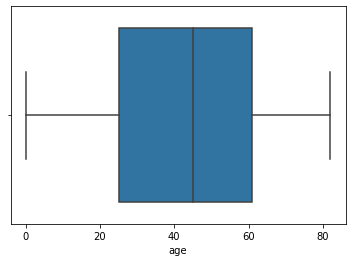

In [ ]:
#@title No outliers in age
sns.boxplot(x=df.age)

In [ ]:
#@title Distribution of all features are all highly possitivley skewed except for age which is slightly negatively skewed.
df.skew(numeric_only=True) # numeric_only=True else error

age                 -0.137059
hypertension         2.715392
heart_disease        3.947244
avg_glucose_level    1.572284
bmi                  1.055340
stroke               4.193284
dtype: float64

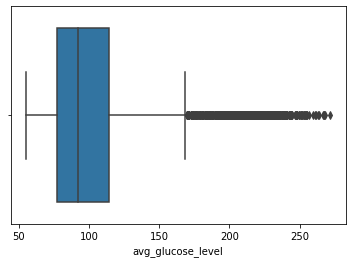

In [ ]:
#@title Outliers noted in df.avg_glucose_level
sns.boxplot(x=df.avg_glucose_level)

In [ ]:
df.avg_glucose_level.max()

271.74

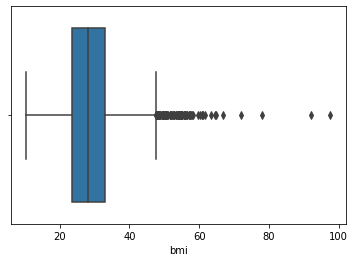

In [ ]:
#@title Outliers noted in df.bmi
sns.boxplot(x=df.bmi)

In [ ]:
df.bmi.max()

97.6

##### **Label Value - df.stroke**

The target value to be predicted is df.stroke. This a a binary feature with 1 to indicate possitive for stroke and 0 to indicate not possitive for stroke.

In [ ]:
df.stroke.value_counts()

0    4861
1     249
Name: stroke, dtype: int64

High imbalance with a low value count for the possitive prediction. 

The label data is imbalanced, this is consistent with expectations as more people don't have stroke than do. Further consideration should be done on the negative affect this may have on the models. [Possible solutions](https://www.analyticsvidhya.com/blog/2020/07/10-techniques-to-deal-with-class-imbalance-in-machine-learning/).

In [ ]:
#@title Population Stroke Rate
stroke_rate = df.stroke.mean()
round(stroke_rate,2)

0.05

Exact data on stroke prevelance is not avaible but some estimations can be made. From this [report](https://n.neurology.org/content/97/20_Supplement_2/S6) we know that the annual incident for stroke is ~3% in the US. Globally it varies by country economic status, with lower countries often having higher rates (see fig 2 in link). From that we can assume the 5% seen here is roughly representative of the real world stroke incident. Though potentially a little low as some of higher countries (such as China) have very large populations.

##### **df.age**

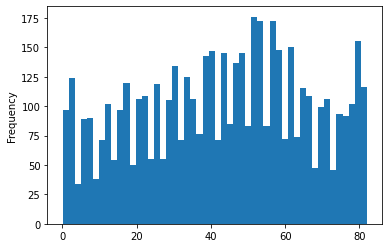

In [ ]:
df.age.plot.hist(bins=50)

In [ ]:
df.age.value_counts()

78.00    102
57.00     95
52.00     90
54.00     87
51.00     86
        ... 
1.40       3
0.48       3
0.16       3
0.40       2
0.08       2
Name: age, Length: 104, dtype: int64

Clarification on age [here](https://www.kaggle.com/datasets/fedesoriano/stroke-prediction-dataset/discussion/223242?search=age), decimal places represent days. 

##### **df.bmi**

###### **Missing values**
[Missing Value Guide](https://www.analyticsvidhya.com/blog/2021/10/handling-missing-value/)
Fill missing values based on groups of either possitive for stroke or not. Suspect possible difference in grouping.

In [ ]:
stroke_bmi_0, stroke_bmi_1 =df.groupby('stroke')['bmi'].mean()
stroke_bmi_0, stroke_bmi_1 # 0 not a stroke and 1 is a stroke

(28.823063829787234, 30.471291866028707)

In [ ]:
round((stroke_bmi_1-stroke_bmi_0)/stroke_bmi_1,2)

0.05

Slight variance of 5% in bmi mean, note dtype is float64

Review the distribution of bmi as a total and by stroke value

((array([-3.6412931, -3.4063133, -3.2768215, ...,  3.2768215,  3.4063133,
          3.6412931]), array([10.3, 11.3, 11.5, ...,  nan,  nan,  nan])),
 (nan, nan, nan))

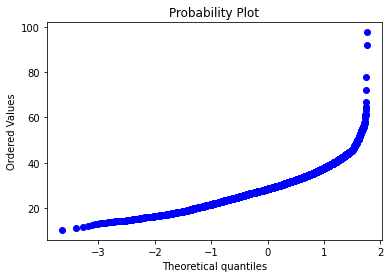

In [ ]:
stats.probplot(df.bmi,fit=True, plot=pylab )

The probability plot shows that the bmi distribution is not normal. Next step is to see if the distribution can be transformed to a normal distribuion for a p-value analysis.

**Normalize df.bmi Distribution**

Distribution can be normalized well enough to calculate a p-value.

[Normalization techniques](https://www.analyticsvidhya.com/blog/2021/05/how-to-transform-features-into-normal-gaussian-distribution/)

In [ ]:
def normality(data,feature):
    plt.figure(figsize=(10,5))
    plt.subplot(1,2,1)
    sns.kdeplot(data[feature])
    plt.subplot(1,2,2)
    stats.probplot(data[feature],plot=pylab)
    plt.show()

In [ ]:
df_cp = df.copy() #must reimport data if this is ran after changes are made.

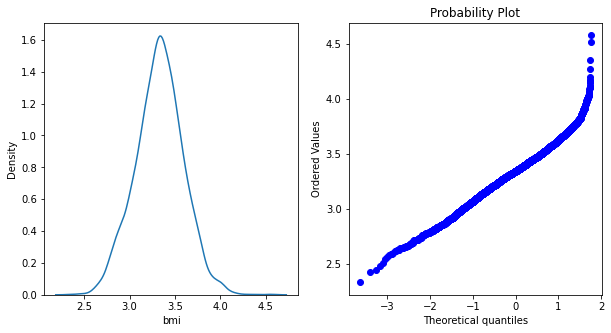

0.0011326087933981655

In [ ]:
#performing logarithmic transformation on the feature
df_bmi = df_cp.copy()
df_bmi.bmi=np.log(df.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

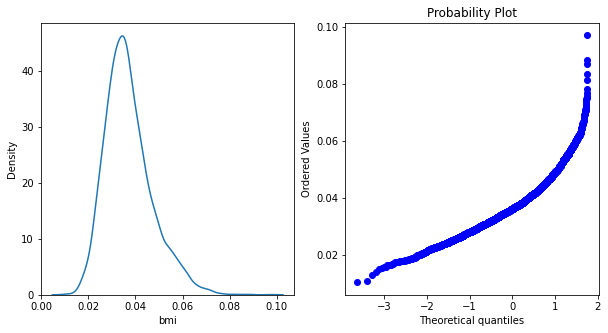

0.8591866889536662

In [ ]:
#Reciprocal Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=1/df_bmi.bmi
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

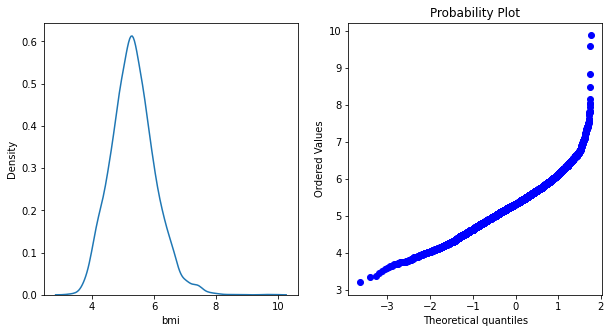

0.4748565689090631

In [ ]:
#Square Root Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=np.sqrt(df_bmi.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

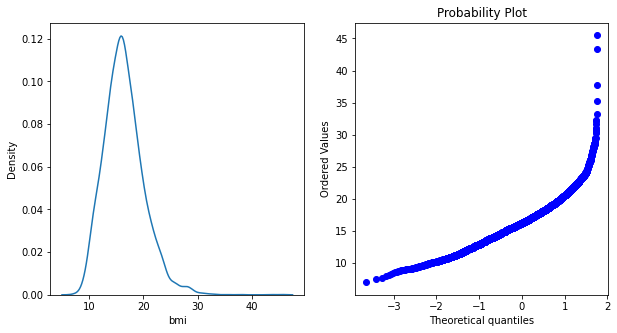

0.8439381127696062

In [ ]:
#Exponential Transformation
df_bmi = df_cp.copy()
df_bmi.bmi=df.bmi**(1/1.2)
normality(df_bmi, 'bmi')
df_bmi.bmi.skew()

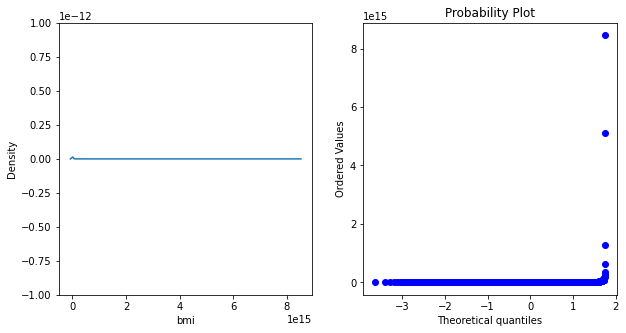

51.59532132895192

In [ ]:
#Box-Cox Transformation
df_bmi = df_cp.copy()
df_bmi.bmi,parameters=stats.boxcox(df_bmi.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

**p-value**
The two sample test shows that the difference in the bmi distributions are NOT statistiacally signifigant. Replacing the missing values with the overall mean is justified.

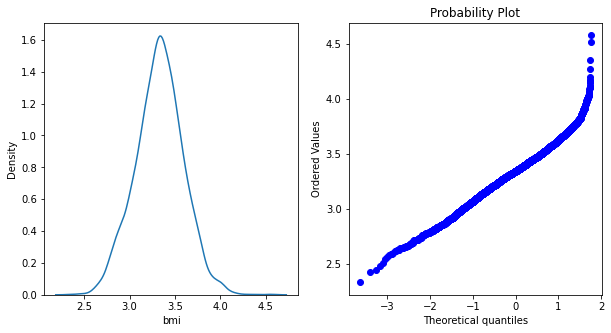

0.0011326087933981655

In [ ]:
df_bmi = df.copy()
df_bmi.bmi=np.log(df.bmi)
normality(df_bmi,'bmi')
df_bmi.bmi.skew()

The distribution is very close to normal, only off by 0.001

stroke
0    AxesSubplot(0.125,0.125;0.775x0.755)
1    AxesSubplot(0.125,0.125;0.775x0.755)
Name: bmi, dtype: object

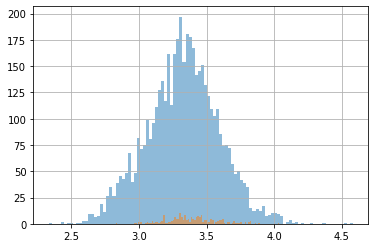

In [ ]:
df_bmi.groupby('stroke')['bmi'].hist(bins=100, alpha=0.5)

In [ ]:
bmi_stroke_0, bmi_stroke_1 =df_bmi.groupby('stroke')['bmi']

In [ ]:
# one sample
stats.ttest_1samp(a=bmi_stroke_1[1],popmean=bmi_stroke_0[0], nan_policy='omit')

Ttest_1sampResult(statistic=244.833779465847, pvalue=6.025963176549174e-258)

The  one sample test shows that the difference in the bmi distributions are **NOT** statistiacally signifigant. Replacing the missing values with the overall median is justified. I chose median due the current outliers affecting the mean.

**Fill Missing Values**

In [ ]:
df.bmi = df.bmi.fillna(df.bmi.median())

###### **Manage Outliers**

[Outliers Guide](https://www.analyticsvidhya.com/blog/2021/05/detecting-and-treating-outliers-treating-the-odd-one-out/) 

In [ ]:
df.bmi.value_counts(bins=15).sort_values()

(80.14, 85.96]        0
(85.96, 91.78]        0
(68.5, 74.32]         1
(74.32, 80.14]        1
(91.78, 97.6]         2
(62.68, 68.5]         4
(56.86, 62.68]       13
(51.04, 56.86]       43
(45.22, 51.04]       86
(10.212, 16.12]     100
(39.4, 45.22]       299
(33.58, 39.4]       690
(16.12, 21.94]      774
(21.94, 27.76]     1501
(27.76, 33.58]     1596
Name: bmi, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

Without a height metric, these outliers are assumed to be natural variants in the population.

[BMI](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html)

###### **Obese Feature**

However, we do [know](https://www.cancer.org/healthy/cancer-causes/diet-physical-activity/body-weight-and-cancer-risk/adult-bmi.html) that people with a bmi of 30 or greater qualify as obese.

In [ ]:
df['obese'] = df['bmi'] >=30

In [ ]:
df.head(2)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,obese
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,True
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,False


In [ ]:
df['obese'] = df['obese'].astype(int)
df['obese'].value_counts()

0    3190
1    1920
Name: obese, dtype: int64

##### **df.avg_glucose_level**

###### **P-value avg_glucose_level**

Reseach shows that Categorizing to above and below a bloodsugar limit may improve predictions.

 [Cleavland Clinic](https://my.clevelandclinic.org/health/diseases/9812-diabetes-and-stroke#:~:text=Your%20body%20can't%20make,Extra%20body%20weight.), [AHA Journal](https://www.ahajournals.org/doi/full/10.1161/01.str.0000115297.92132.84), [stroke.org.uk](https://www.stroke.org.uk/what-is-stroke/are-you-at-risk-of-stroke/diabetes), [Stroke.org - Diabetes](https://www.stroke.org/en/about-stroke/stroke-risk-factors/diabetes-and-stroke-prevention). 

In [ ]:
stroke_glucose_0, stroke_glucose_1 =df.groupby('stroke')['avg_glucose_level'].mean()
stroke_glucose_0, stroke_glucose_1 # 0 not a stroke and 1 is a stroke

(104.79551326887471, 132.54473895582328)

In [ ]:
round((stroke_glucose_1-stroke_glucose_0)/stroke_glucose_1,2)

0.21

A small variance in the mean of avg_glucose_level of 18%.

In [ ]:
# stroke negative
stroke_gluc_0, stroke_gluc_1 =df.groupby('stroke')['avg_glucose_level']
stroke_gluc_0[1].describe()

count    4861.000000
mean      104.795513
std        43.846069
min        55.120000
25%        77.120000
50%        91.470000
75%       112.830000
max       267.760000
Name: avg_glucose_level, dtype: float64

In [ ]:
# stroke possitive
stroke_gluc_1[1].describe()

count    249.000000
mean     132.544739
std       61.921056
min       56.110000
25%       79.790000
50%      105.220000
75%      196.710000
max      271.740000
Name: avg_glucose_level, dtype: float64

###### **Normallize avg_glucose_level**

((array([-3.6412931, -3.4063133, -3.2768215, ...,  3.2768215,  3.4063133,
          3.6412931]),
  array([ 55.12,  55.22,  55.23, ..., 267.61, 267.76, 271.74])),
 (40.678945925100635, 106.1476771037182, 0.8978160806829297))

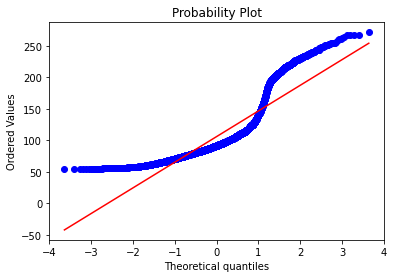

In [ ]:
stats.probplot(df.avg_glucose_level,fit=True, plot=pylab )

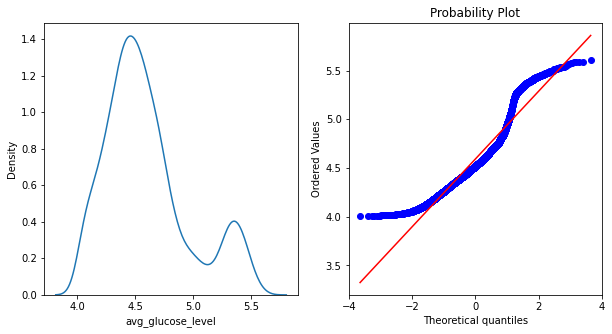

0.8827511014266456

In [ ]:
#performing logarithmic transformation on the feature
df2 = df.copy()
df2.avg_glucose_level=np.log(df.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

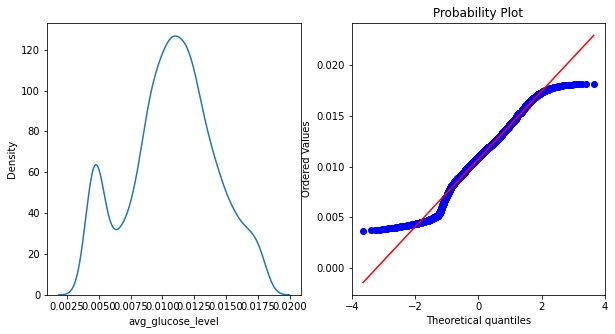

-0.12577378741588255

In [ ]:
#Reciprocal Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=1/df2.avg_glucose_level
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

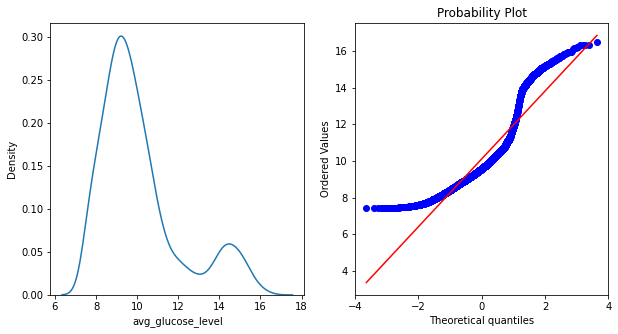

1.2427218676251186

In [ ]:
#Square Root Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=np.sqrt(df2.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

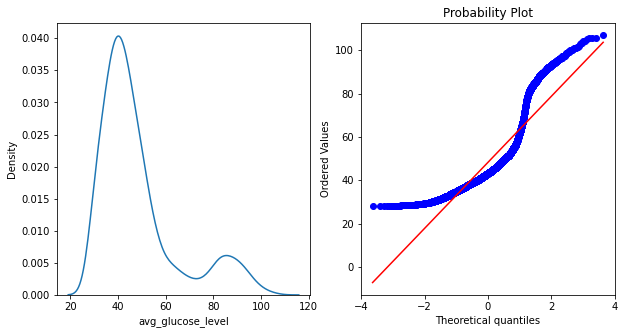

1.4662829646834146

In [ ]:
#Exponential Transformation
df2 = df_cp.copy()
df2.avg_glucose_level=df.avg_glucose_level**(1/1.2)
normality(df2, 'avg_glucose_level')
df2.avg_glucose_level.skew()

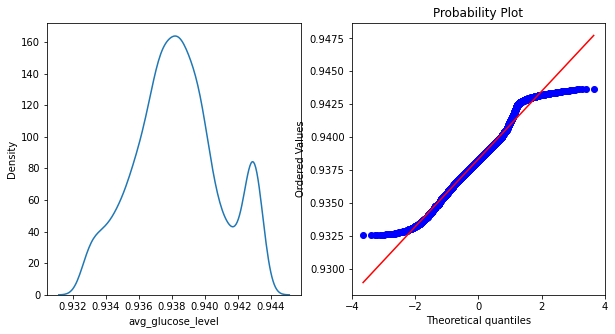

0.08329904162034814

In [ ]:
#Box-Cox Transformation
df2 = df_cp.copy()
df2.avg_glucose_level,parameters=stats.boxcox(df2.avg_glucose_level)
normality(df2,'avg_glucose_level')
df2.avg_glucose_level.skew()

###### **Final Decision**

* Unable to normalize the distribution avg_glucose_level
* Unable to get reliable p-value due to distribution

Despite research indicating a clear delineation with high blood sugar and stroke, I am not able to confirm that with the current understanding of the relationship from this data. No justification for categorizing avg_glucose_level based on reported glucose ranges should be done without further external reseach or more data.

###### **Outliers avg_glucose_level**

In [ ]:
df['avg_glucose_level'].max()

271.74

In [ ]:
df['avg_glucose_level'].min()

55.12

In [ ]:
df.avg_glucose_level.value_counts(bins=15).sort_values()

(257.299, 271.74]       10
(242.857, 257.299]      35
(170.651, 185.092]      61
(156.209, 170.651]      71
(228.416, 242.857]      88
(141.768, 156.209]     113
(185.092, 199.533]     119
(213.975, 228.416]     145
(127.327, 141.768]     150
(199.533, 213.975]     162
(112.885, 127.327]     370
(54.902, 69.561]       728
(98.444, 112.885]      746
(84.003, 98.444]      1142
(69.561, 84.003]      1170
Name: avg_glucose_level, dtype: int64

Some outliers represent natural variations in the population, and they should be left as is in your dataset. These are called true outliers. Other outliers are problematic and should be removed because they represent measurement errors, data entry or processing errors, or poor sampling.

**Average glucose(a.k.a. blood sugar) level is measured though an A1C or HbA1c test.**

For a normal person blood sugar can get up to 140 per the [American Diabetes Association](https://diabetesjournals.org/care/article/24/4/775/23438/Postprandial-Blood-Glucose), but diabetes is diagnosed when **AVERAGE** blood sugar is 140 or higher. However, people with Diabetes can get much higher than on this data set. Without a diabetes diagnosis it is not possible to determine if the outliers are inaccurate data. However, it is possible to interpet those above 140 as clearly having diabetes.

Note, being below 140 does NOT signify someone does not have diabetes. They may simply be well controlled. Most type one diabetics aim for an average blood sugar of 140, while type two aim to be below that level.. 

###### **Clearly Diabetes**

In [ ]:
df['clearly_diabetes'] = df['avg_glucose_level'] >= 140

In [ ]:
df.head(3)

,gender,age,hypertension,heart_disease,ever_married,work_type,residence_type,avg_glucose_level,bmi,smoking_status,stroke,obese,clearly_diabetes
0,Male,67.0,0,1,Yes,Private,Urban,228.69,36.6,formerly smoked,1,1,True
1,Female,61.0,0,0,Yes,Self-employed,Rural,202.21,28.1,never smoked,1,0,True
2,Male,80.0,0,1,Yes,Private,Rural,105.92,32.5,never smoked,1,1,False


In [ ]:
df['clearly_diabetes'].replace({False: 0, True: 1}, inplace=True)
df['clearly_diabetes'].value_counts()

0    4289
1     821
Name: clearly_diabetes, dtype: int64

##### **df.gender**

In [ ]:
df.gender.value_counts()

Female    2994
Male      2115
Other        1
Name: gender, dtype: int64

While sexual orientation is not binary, gender is considered binary. Being only one row, the best solution is to add it to the smaller data set. Resoning that the world population is nearly evenly split and the male population is under represented in this data set.

In [ ]:
df.replace('Other','Male',inplace=True)
df.gender.value_counts()

Female    2994
Male      2116
Name: gender, dtype: int64

##### **df.ever_married**

In [ ]:
df.ever_married.value_counts()

Yes    3353
No     1757
Name: ever_married, dtype: int64

In [ ]:
# convert Yes and No to 1 and 0.
df.ever_married = (df.ever_married == 'Yes').astype(int)
df.ever_married.value_counts()

1    3353
0    1757
Name: ever_married, dtype: int64

##### **Multi-categories** pd.dummies for further anlysis

In [ ]:
df_dummies = df.copy()

In [ ]:
#@title df_dummies.gender
dummies = pd.get_dummies(df_dummies.gender)
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['gender']
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married', 'work_type',
       'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'obese', 'clearly_diabetes', 'Female', 'Male'],
      dtype='object')

###### **df_dummies.work_type**

In [ ]:
df_dummies.work_type.value_counts()

Private          2925
Self-employed     819
children          687
Govt_job          657
Never_worked       22
Name: work_type, dtype: int64

In [ ]:
dummies = pd.get_dummies(df_dummies.work_type)
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['work_type']
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'smoking_status',
       'stroke', 'obese', 'clearly_diabetes', 'Female', 'Male', 'Govt_job',
       'Never_worked', 'Private', 'Self-employed', 'children'],
      dtype='object')

###### **df_dummies.smoking_status**

In [ ]:
df_dummies.smoking_status.value_counts()

never smoked       1892
Unknown            1544
formerly smoked     885
smokes              789
Name: smoking_status, dtype: int64

In [ ]:
dummies = pd.get_dummies(df_dummies.smoking_status)
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['smoking_status']
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'residence_type', 'avg_glucose_level', 'bmi', 'stroke', 'obese',
       'clearly_diabetes', 'Female', 'Male', 'Govt_job', 'Never_worked',
       'Private', 'Self-employed', 'children', 'Unknown', 'formerly smoked',
       'never smoked', 'smokes'],
      dtype='object')

###### **df.residence_type**

In [ ]:
df.residence_type.value_counts()

Urban    2596
Rural    2514
Name: residence_type, dtype: int64

In [ ]:
dummies = pd.get_dummies(df_dummies.residence_type)
df_dummies = pd.concat([df_dummies, dummies],axis='columns')
del df_dummies['residence_type']
df_dummies.columns

Index(['age', 'hypertension', 'heart_disease', 'ever_married',
       'avg_glucose_level', 'bmi', 'stroke', 'obese', 'clearly_diabetes',
       'Female', 'Male', 'Govt_job', 'Never_worked', 'Private',
       'Self-employed', 'children', 'Unknown', 'formerly smoked',
       'never smoked', 'smokes', 'Rural', 'Urban'],
      dtype='object')

##### **Final Feature Overview**

###### df_dummies

In [ ]:
# convert new column names to lower
col = df_dummies.columns.tolist()
df_dummies = df_dummies.rename(str.lower, axis='columns')
col = df_dummies.columns.tolist() # list with new column names all lower case


In [ ]:
# confirm column names and dtypes
df_dummies.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
obese                  int64
clearly_diabetes       int64
female                 uint8
male                   uint8
govt_job               uint8
never_worked           uint8
private                uint8
self-employed          uint8
children               uint8
unknown                uint8
formerly smoked        uint8
never smoked           uint8
smokes                 uint8
rural                  uint8
urban                  uint8
dtype: object

Dummy columns may lose context once separated. Renaming columns would make the data more readable. Addionally the name word spacing should use '_' rather than ' ' or '-'.

In [ ]:
df_dummies = df_dummies.rename(columns={'other': 'other_gender','formerly smoked':'formerly_smoked','never smoked':'never_smoked',
                                        'unknown':'unknown_smoking','children': 'is_a_child','private': 'employed',
                                        'self-employed':'self_employed' })

In [ ]:
# Confirm changes
df_dummies.dtypes

age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
avg_glucose_level    float64
bmi                  float64
stroke                 int64
obese                  int64
clearly_diabetes       int64
female                 uint8
male                   uint8
govt_job               uint8
never_worked           uint8
employed               uint8
self_employed          uint8
is_a_child             uint8
unknown_smoking        uint8
formerly_smoked        uint8
never_smoked           uint8
smokes                 uint8
rural                  uint8
urban                  uint8
dtype: object

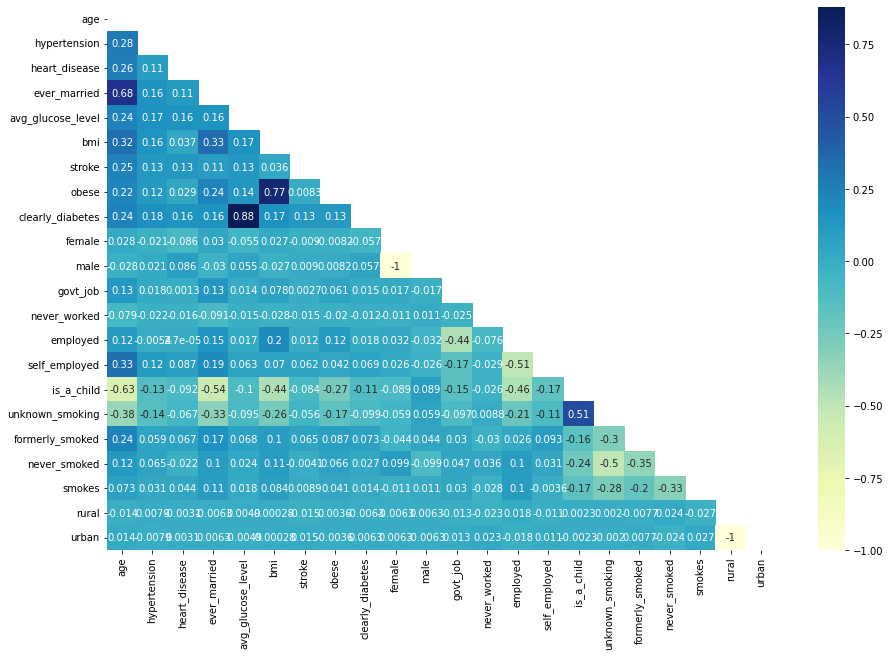

In [ ]:
#@title Review of inter-feature correlation, consider action for highly correlated features.
plt.subplots(figsize=(15,10))

mask = np.triu(np.ones_like(df_dummies.corr())) # triangle mask to hide duplicates

sns.heatmap(df_dummies.corr(),cmap="YlGnBu", annot=True, mask=mask)

None of the **independant** features have a high (0.75+) correlation that may skew models. All feature have a low (< 0.50) to moderate (0.50 >< 0.75) correlation. 

Note: High correlation is acceptable for dependant features. The clearly_diabetes and obese columns are our only depenant columns.

In [ ]:
#@title Data Skew
df_dummies.skew().sort_values(ascending=False)

never_worked         15.146344
stroke                4.193284
heart_disease         3.947244
hypertension          2.715392
govt_job              2.219958
is_a_child            2.143866
smokes                1.913452
self_employed         1.852619
clearly_diabetes      1.848660
formerly_smoked       1.727782
avg_glucose_level     1.572284
bmi                   1.088187
unknown_smoking       0.861974
never_smoked          0.537548
obese                 0.513317
male                  0.348930
rural                 0.032107
urban                -0.032107
age                  -0.137059
employed             -0.292800
female               -0.348930
ever_married         -0.657745
dtype: float64

Much of the data is far from a Gaussian (normal) distribution. This may negatively affect model performance and is likely due to the sampling of data made avaiable on Kaggle. Consider [QuantileTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.QuantileTransformer.html#sklearn.preprocessing.QuantileTransformer) and [PowerTransformer](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PowerTransformer.html#sklearn.preprocessing.PowerTransformer).

<a name="baseline"></a>
# Modeling

The modeling proccess is to first test possable viable models, then select the best models, and create a baseline to compare the tuning process against. 

**Linear Regression** is a poor choice for clasification output problems and better suited for continuous output problems. While the label is binary the model could provide values outside of that range.

Researching ML models and the general concesses from ML engineers show the following models best for our label which is a binary classifier (stroke 1 or 0). There are numerous articles and research papers but this [article](https://towardsdatascience.com/pros-and-cons-of-various-classification-ml-algorithms-3b5bfb3c87d6) and this [article](https://towardsdatascience.com/top-10-binary-classification-algorithms-a-beginners-guide-feeacbd7a3e2) sum up the reasoning.

### Data Prep

In [ ]:
#@title Split: df_train / df_test

df_train, df_test = train_test_split(df, test_size=0.2, random_state=1)

df_train = df_train.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)


y_train = df_train.stroke.values
y_test = df_test.stroke.values

del df_train['stroke']
del df_test['stroke']

In [ ]:
df_train.shape

(4088, 12)

In [ ]:
len(y_train)

4088

In [ ]:
#@title x_train
train_dict = df_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_train = dv.fit_transform(train_dict)


In [ ]:
#@title x_test
test_dict = df_test.to_dict(orient='records')
x_test = dv.transform(test_dict)

In [ ]:
#@title def training_smote(x,y) - to address the stroke imbalance

# ONLY APPLY SMOTE TO TRAIN!
def training_smote(x,y):
    smt = SMOTE(random_state=1)
    x_train, y_train = smt.fit_resample(x, y)
    return x_train, y_train

In [ ]:
#@title def model_run(models)
def model_run(models):
  models_score = []
  for name, model in models:
      model = model
      model.fit(x_train, y_train)
      model.predict(x_test)
      models_score.append([name, accuracy_score(y_test, model.predict(x_test))])
      
      print(" ")
      print("Model: ",name)
      print('Testing Accuracy: ', accuracy_score(y_test, model.predict(x_test)))
      print('Training Accuracy: ', accuracy_score(y_train, model.predict(x_train)))
      print(" ")
      
      plt.figure()
      cf_matrix = confusion_matrix(y_test, model.predict(x_test))
      plt.title('Confusion Matrix: {}'.format(name))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.show()
      
      print(" ")

      skplt.metrics.plot_roc(y_test, model.predict_proba(x_test))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

In [ ]:
x_train, y_train = training_smote(x_train, y_train)

### Model Comparison

In [ ]:
#@title Model Selection
models = [('Logistic Regression', LogisticRegression(max_iter=1000,random_state=1)), # max_iter=1000 due to error
          ('Decision Tree Classifier', DecisionTreeClassifier(random_state=1)),
          ('Random Forest', RandomForestClassifier(random_state=1)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Ada Boost', AdaBoostClassifier(random_state=1)),
          ('KNN', KNeighborsClassifier()),
          ('Support Vector Machine', SVC(probability = True)),
          ('XG Boost', XGBClassifier(random_state=1)),
          ('Cat Boost', CatBoostClassifier(logging_level = 'Silent')),
          ('Naive Bayes', ComplementNB())]

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


 
Model:  Logistic Regression
Testing Accuracy:  0.7514677103718199
Training Accuracy:  0.7735316747884072
 


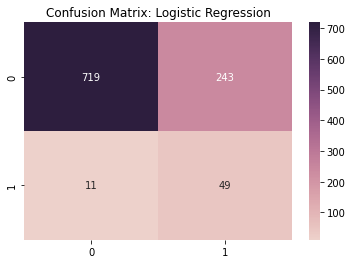

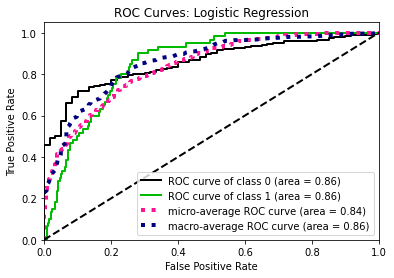

 
Model:  Decision Tree Classifier
Testing Accuracy:  0.8904109589041096
Training Accuracy:  1.0
 


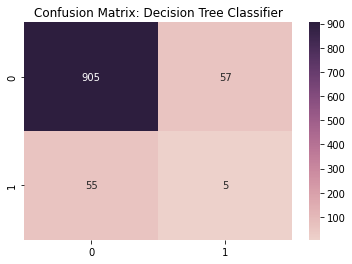

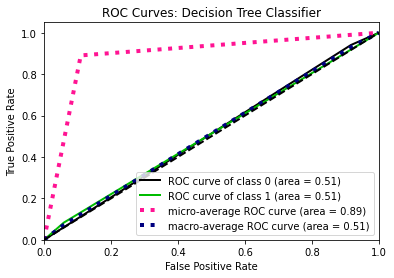

 
Model:  Random Forest
Testing Accuracy:  0.9344422700587084
Training Accuracy:  1.0
 


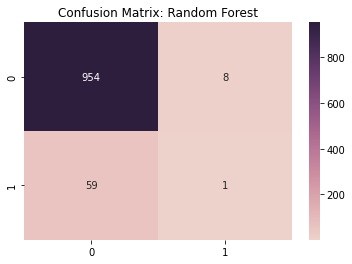

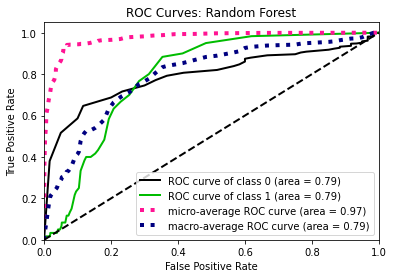

 
Model:  Linear Discriminant Analyzer
Testing Accuracy:  0.7416829745596869
Training Accuracy:  0.7768658630418056
 


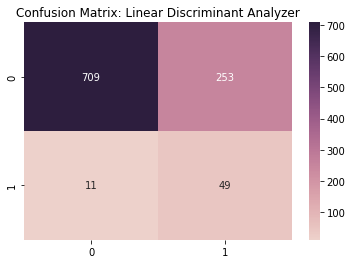

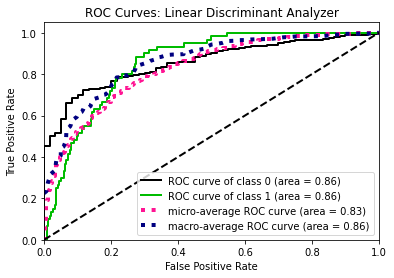

 
Model:  Ada Boost
Testing Accuracy:  0.9305283757338552
Training Accuracy:  0.9626827391638881
 


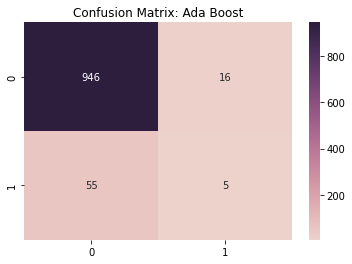

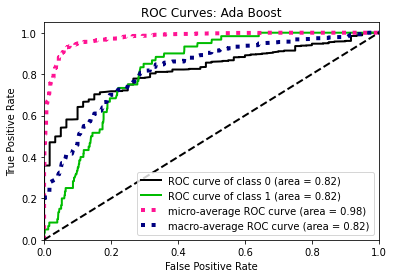

 
Model:  KNN
Testing Accuracy:  0.7886497064579256
Training Accuracy:  0.9183123877917415
 


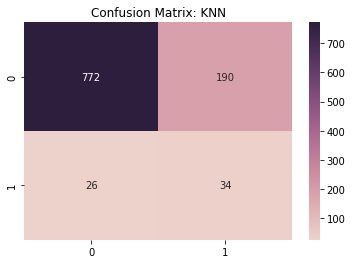

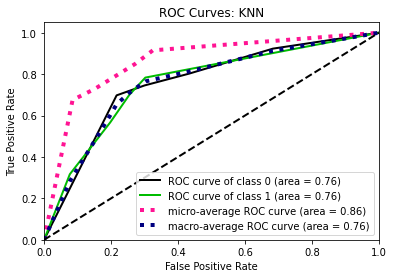

 
Model:  Support Vector Machine
Testing Accuracy:  0.7211350293542075
Training Accuracy:  0.7559630674531931
 


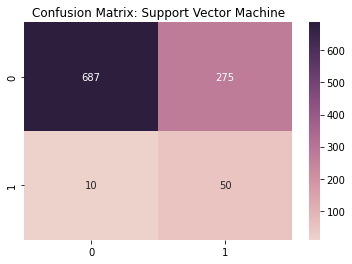

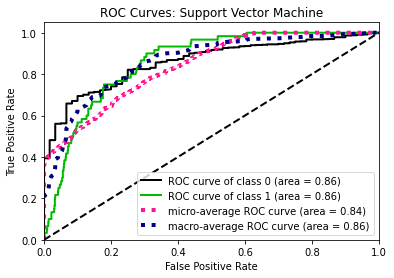

 
Model:  XG Boost
Testing Accuracy:  0.9383561643835616
Training Accuracy:  0.973967684021544
 


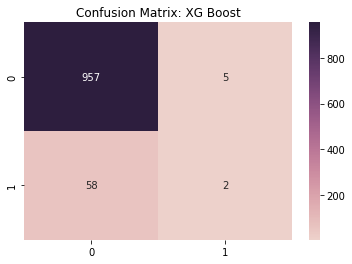

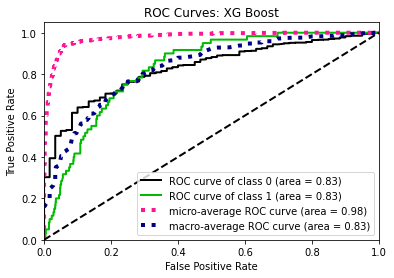

 
Model:  Cat Boost
Testing Accuracy:  0.9315068493150684
Training Accuracy:  0.9907668632982816
 


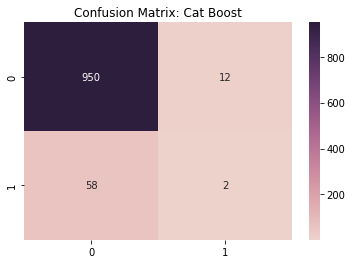

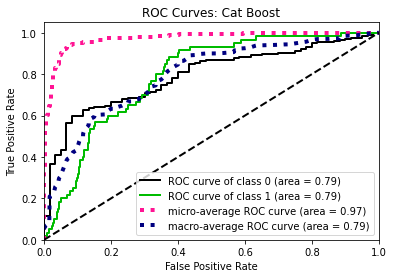

 
Model:  Naive Bayes
Testing Accuracy:  0.6565557729941291
Training Accuracy:  0.7078738137984099
 


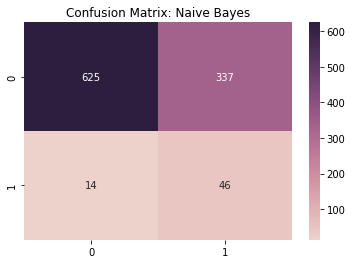

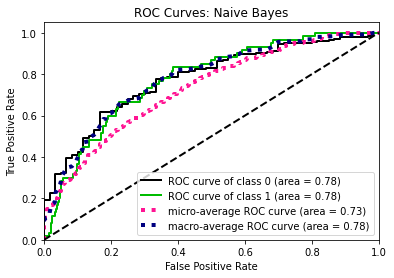

In [ ]:
#@title Run all models
model_run(models)

Regarding [convergence error](https://stackoverflow.com/questions/62658215/convergencewarning-lbfgs-failed-to-converge-status-1-stop-total-no-of-iter)

### Best Performing Models

**While the score may not be the highest, these models were the best at predicting a stroke. The trade off is lower non-stroke accuracy. In the case of healthcare, we would rather capture non-stroke than miss actual strokes.**

In [ ]:
#@title Selected Models
selected_models = [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=1)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis()),
          ('Support Vector Machine', SVC(probability = True,random_state=1))]

 
Model:  Logistic Regression
Testing Accuracy:  0.7514677103718199
Training Accuracy:  0.7735316747884072
 


/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


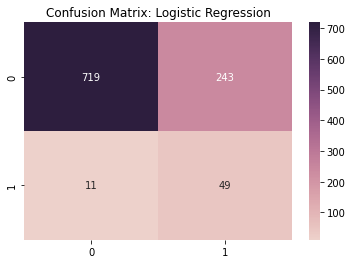

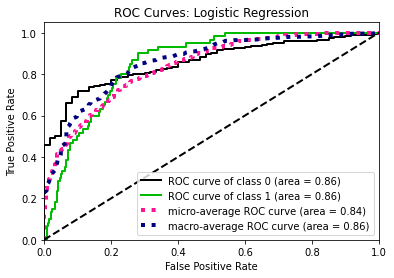

 
Model:  Linear Discriminant Analyzer
Testing Accuracy:  0.7416829745596869
Training Accuracy:  0.7768658630418056
 


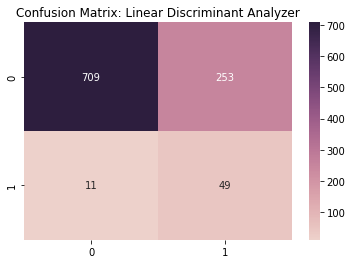

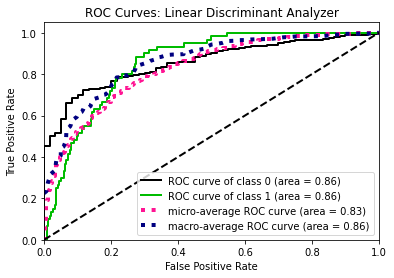

 
Model:  Support Vector Machine
Testing Accuracy:  0.7211350293542075
Training Accuracy:  0.7559630674531931
 


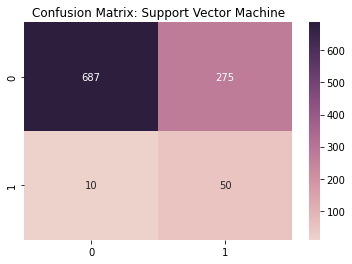

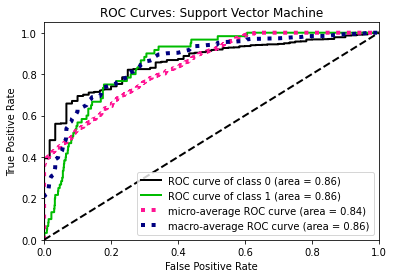

In [ ]:
model_run(selected_models)

<a name="tuning"></a>
# Tuning

The tuning process consists of adjusting and measuring model parameters, and, if needed, revisiting feature engineering.

**Best Preforming Model**

LogisticRegresion has a slight lead over Linear Discriminant Analyzer with ~0.75 and ~0.77 for testing and training accuracy respectively. 

SVC did worse than either with ~0.72 and ~0.76 but slightly better with possitive stroke prediciton.

**Overview**

Comparison of the models in the variable `selected_models`:

* **Logistic Regression**, `LogisticRegression()`
  * *Testing Accuracy:  0.7485322896281801*
  * *Training Accuracy:  0.7677609643498333*
  * 11/49 or 22% miss rate for possitive stroke
* **Linear Discriminant Analyzer**, `LinearDiscriminantAnalysis()`
  * *Testing Accuracy:  0.738747553816047*
  * *Training Accuracy:  0.7686586304180559*
  * 11/49 or 22% miss rate for possitive stroke
* **Support Vector Machine**, `SVC(probability = True)`
  * *Testing Accuracy:  0.7172211350293543*
  * *Training Accuracy:  0.7575019235701462* 
  * 10/49 or 20% miss rate for possitive stroke

In [ ]:
#@title Top two
two_models = [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=1)),
          ('Linear Discriminant Analyzer', LinearDiscriminantAnalysis())]

<a name="feat_imp"></a>
## Feature Importance - [article](https://machinelearningmastery.com/calculate-feature-importance-with-python/)

### Feature Importance Model

In [ ]:
X = x_train.copy()
y = y_train.copy()

In [ ]:
my_list = [LogisticRegression(max_iter=2000, random_state=1),LinearDiscriminantAnalysis()]

In [ ]:
#@title Feature Rank
for model in my_list:
    rfe = RFECV(estimator=model,step=1,cv=5)
    rfe.fit(X,y)
    print(" ")
    print(model)
    print(" ")
    for j, col, in zip(range(df.shape[1]), df.columns):
      print(f'{col} selected= {rfe.support_[1]} rank= {rfe.ranking_[1]}')

 
LogisticRegression(max_iter=2000, random_state=1)
 
gender selected= True rank= 1
age selected= True rank= 1
hypertension selected= True rank= 1
heart_disease selected= True rank= 1
ever_married selected= True rank= 1
work_type selected= True rank= 1
residence_type selected= True rank= 1
avg_glucose_level selected= True rank= 1
bmi selected= True rank= 1
smoking_status selected= True rank= 1
stroke selected= True rank= 1
obese selected= True rank= 1
clearly_diabetes selected= True rank= 1
 
LinearDiscriminantAnalysis()
 
gender selected= True rank= 1
age selected= True rank= 1
hypertension selected= True rank= 1
heart_disease selected= True rank= 1
ever_married selected= True rank= 1
work_type selected= True rank= 1
residence_type selected= True rank= 1
avg_glucose_level selected= True rank= 1
bmi selected= True rank= 1
smoking_status selected= True rank= 1
stroke selected= True rank= 1
obese selected= True rank= 1
clearly_diabetes selected= True rank= 1


In [ ]:
#@title Get Feature Names
feat_names = dv.get_feature_names_out()

In [ ]:
#@title def feature_importance(model)
def feature_importance(model):
    # define the model
    model = model
    # fit the model
    model.fit(X, y)
    # get importance
    importance = model.coef_[0]
    # summarize feature importance
    for i,v in enumerate(importance):
        print(f'Feature: {feat_names[i]}',' ',f'Score: {v}\n')

In [ ]:
#@title Logistic Feature coefficients

feature_importance(LogisticRegression(max_iter=1000, random_state=1))

Feature: age   Score: 0.08086238116013078

Feature: avg_glucose_level   Score: -0.0031192823867752764

Feature: bmi   Score: 0.001637227504805232

Feature: clearly_diabetes   Score: 0.8435808022250201

Feature: ever_married   Score: -0.34749071070785215

Feature: gender=Female   Score: -0.31738281700960197

Feature: gender=Male   Score: -0.4909374199245032

Feature: heart_disease   Score: 0.387353298132142

Feature: hypertension   Score: 0.6970545946474596

Feature: obese   Score: -0.19858654573706117

Feature: residence_type=Rural   Score: -0.4976492898484846

Feature: residence_type=Urban   Score: -0.3106709470774563

Feature: smoking_status=Unknown   Score: -0.24009264560287713

Feature: smoking_status=formerly smoked   Score: -0.0718010952392158

Feature: smoking_status=never smoked   Score: -0.3406160552951326

Feature: smoking_status=smokes   Score: -0.15581044080374598

Feature: work_type=Govt_job   Score: -0.12110641157698386

Feature: work_type=Never_worked   Score: -1.0893768

/usr/local/lib/python3.7/dist-packages/sklearn/linear_model/_logistic.py:818: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG,


In [ ]:
#@title Linear Discriminant Feature coefficients

feature_importance(LinearDiscriminantAnalysis())
   
# plot feature importance
#pyplot.bar([x for x in range(len(importance))], importance)
#pyplot.show()

Feature: age   Score: 0.09546766943049866

Feature: avg_glucose_level   Score: -0.0025961907768639494

Feature: bmi   Score: -0.0015987424678805032

Feature: clearly_diabetes   Score: 0.9225152748835044

Feature: ever_married   Score: -0.541372732510633

Feature: gender=Female   Score: 0.08196113192089058

Feature: gender=Male   Score: -0.08196113192089122

Feature: heart_disease   Score: 0.4237035812798653

Feature: hypertension   Score: 0.7654668192212444

Feature: obese   Score: -0.2304448217741472

Feature: residence_type=Rural   Score: -0.08942807030283567

Feature: residence_type=Urban   Score: 0.08942807030283531

Feature: smoking_status=Unknown   Score: 0.024554883834108254

Feature: smoking_status=formerly smoked   Score: 0.16423676980064567

Feature: smoking_status=never smoked   Score: -0.13075258471153

Feature: smoking_status=smokes   Score: -0.006000121895756576

Feature: work_type=Govt_job   Score: -0.33757022055014796

Feature: work_type=Never_worked   Score: 0.35716110

Both heart_disease and hypertension have high possitive coefficients, this is consistent studies showing that both diseases greatly increase your likelihood of having a stroke. [Cardiovascular risk factors](https://www.ncbi.nlm.nih.gov/pmc/articles/PMC4419105/)

The second highest possitive coefficients is for work_type=children despte research showing that stroke in children is [rare](https://www.hopkinsmedicine.org/health/conditions-and-diseases/stroke/pediatric-stroke).

The obese feature may be confusing the models, as we are seeing inconsistent accounting for it, despite it being a known to [increase the likelihood](https://ochsnerlg.org/about-us/news/how-obesity-affects-stroke-risk#:~:text=Effects%20of%20Obesity&text=Repeated%20studies%20estimate%20that%20each,of%20stroke%20by%2050%20percent.) of stroke.

In [ ]:
df[df.work_type == 'children'].stroke.value_counts()

0    685
1      2
Name: stroke, dtype: int64

## Feature Importance Data

In [ ]:
#@title Data split for feature importance fi_train, fi_test
fi_train, fi_test = train_test_split(df, test_size=0.2, random_state=1)

In [ ]:
fi_train.dtypes

gender                object
age                  float64
hypertension           int64
heart_disease          int64
ever_married           int64
work_type             object
residence_type        object
avg_glucose_level    float64
bmi                  float64
smoking_status        object
stroke                 int64
obese                  int64
clearly_diabetes       int64
dtype: object

In [ ]:
categorical = ['smoking_status','residence_type','work_type','gender']

In [ ]:
#@title Feature Importance Breakdown

for c in categorical:
    print(c)
    df_group = fi_train.groupby(c).stroke.agg(['mean','count'])
    df_group['diff'] = df_group['mean'] - stroke_rate
    df_group['risk'] = df_group['mean'] / stroke_rate
    display(df_group)
    print('\n')

smoking_status


,mean,count,diff,risk
smoking_status,,,,
Unknown,0.030376,1251,-0.018352,0.623373
formerly smoked,0.071629,712,0.022901,1.469981
never smoked,0.047428,1497,-0.001300,0.973325
smokes,0.046178,628,-0.002550,0.947676




residence_type


,mean,count,diff,risk
residence_type,,,,
Rural,0.042289,2010,-0.006439,0.867850
Urban,0.050048,2078,0.001320,1.027092




work_type


,mean,count,diff,risk
work_type,,,,
Govt_job,0.046065,521,-0.002663,0.945355
Never_worked,0.000000,19,-0.048728,0.000000
Private,0.049441,2326,0.000713,1.014635
Self-employed,0.072838,659,0.024110,1.494780
children,0.003552,563,-0.045176,0.072903




gender


,mean,count,diff,risk
gender,,,,
Female,0.047919,2379,-0.000809,0.983404
Male,0.043885,1709,-0.004843,0.900618


In [ ]:
def mutual_stroke(series):
    return mutual_info_score(series,fi_train['stroke'])

In [ ]:
mi = fi_train[categorical].apply(mutual_stroke)
mi.sort_values(ascending=False)

work_type         0.006146
smoking_status    0.002092
residence_type    0.000171
gender            0.000045
dtype: float64


**Of note:**
The categorical columns are low overall predictors. Within smoking, formerly_smoked is a high predictor however. 


In [ ]:
#@title Feature Stroke Correlation
fi_train.corr()['stroke'].sort_values(ascending=False).iloc[1:] # if using different dataframes, use df1.corrwith(df2)

age                  0.235947
heart_disease        0.132295
hypertension         0.124816
clearly_diabetes     0.119560
avg_glucose_level    0.117430
ever_married         0.092905
bmi                  0.035747
obese                0.014994
Name: stroke, dtype: float64

**Feature Stroke Correlation**: The top 4 correlated features are consistent with expected highs correlations. 

**Unexpected**: That 'ever_married' being slightly higher than 'formerly_smoked' and 'obese' appear to be negligible.

In [ ]:
df_fi = df.drop(categorical, axis='columns')

## Feature Importance Testing




In [ ]:
#@title Data set without categorical columns

# DataFrame dropping categorical colums
df_fi = df.drop(categorical, axis='columns')

# Splitting data
df_fi_train, df_fi_test = train_test_split(df_fi, test_size=0.2, random_state=1)

df_fi_train = df_fi_train.reset_index(drop=True)
df_fi_test = df_fi_test.reset_index(drop=True)


y_fi_train = df_fi_train.stroke.values
y_fi_test = df_fi_test.stroke.values

del df_fi_train['stroke']
del df_fi_test['stroke']

# x_fi_train
train_dict = df_fi_train.to_dict(orient='records')

dv = DictVectorizer(sparse=False)
x_fi_train = dv.fit_transform(train_dict)

# x_fi_test
test_dict = df_fi_test.to_dict(orient='records')
x_fi_test = dv.transform(test_dict)

In [ ]:
#@title def fi_model_run(models)
def fi_model_run(models):
  models_score = []
  for name, model in models:
      model = model
      model.fit(x_fi_train, y_fi_train)
      model.predict(x_fi_test)
      models_score.append([name, accuracy_score(y_fi_test, model.predict(x_fi_test))])
      
      print(" ")
      print("Model: ",name)
      print('Testing Accuracy: ', accuracy_score(y_fi_test, model.predict(x_fi_test)))
      print('Training Accuracy: ', accuracy_score(y_fi_train, model.predict(x_fi_train)))
      print(" ")
      
      plt.figure()
      cf_matrix = confusion_matrix(y_fi_test, model.predict(x_fi_test))
      plt.title('Confusion Matrix: {}'.format(name))
      sns.heatmap(cf_matrix, annot = True, fmt = 'g', cmap = sns.cubehelix_palette(as_cmap=True))
      plt.show()
      
      print(" ")

      skplt.metrics.plot_roc(y_fi_test, model.predict_proba(x_fi_test))
      plt.title('ROC Curves: {}'.format(name))
      plt.show()

 
Model:  Logistic Regression
Testing Accuracy:  0.7485322896281801
Training Accuracy:  0.7660938702231341
 


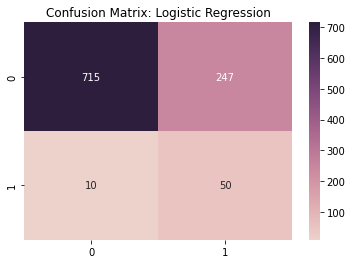

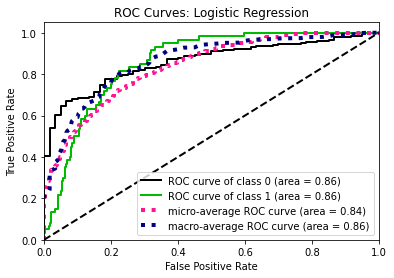

 
Model:  Linear Discriminant Analyzer
Testing Accuracy:  0.738747553816047
Training Accuracy:  0.7654526801744037
 


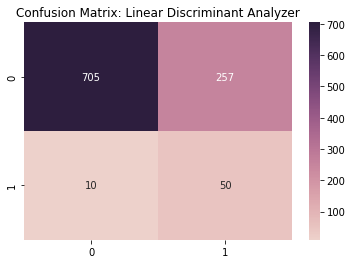

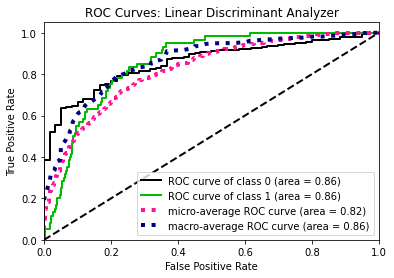

In [ ]:
fi_model_run(two_models)

**Logistic Regression**, `LogisticRegression()`

Before:
* *Testing Accuracy:  0.7485322896281801*
* *Training Accuracy:  0.7677609643498333*
* 11/49 or 22% miss rate for possitive stroke

After:
* *Testing Accuracy:  0.7485322896281801* **negligible improvement**
* *Training Accuracy:  0.7660938702231341* **negligible improvement**
* 10/50 or 20% miss rate for possitive stroke **improved**

**Linear Discriminant Analyzer**, `LinearDiscriminantAnalysis()`

Before:
* *Testing Accuracy:  0.738747553816047*
* *Training Accuracy:  0.7686586304180559*
* 11/49 or 22% miss rate for possitive stroke

After:
* Testing Accuracy:  0.738747553816047 **no change**
* Training Accuracy:  0.7654526801744037 **negligible decline**
* 10/50 or 20% miss rate for possitive stroke **improved**

## Model Tuning

### LogisticRegression Tunning
[Article](https://machinelearningmastery.com/hyperparameters-for-classification-machine-learning-algorithms/)

In [ ]:
log_model = LogisticRegression(max_iter=1000, random_state=1)

In [ ]:
# define LogisticRegression and parameters
model = log_model
solvers = ['newton-cg', 'lbfgs', 'liblinear']
penalty = ['l2']
c_values = [100, 10, 1.0, 0.1, 0.01]
# define grid search
grid = dict(solver=solvers,penalty=penalty,C=c_values)
cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
grid_search = GridSearchCV(estimator=model, param_grid=grid, n_jobs=-1, cv=cv, scoring='accuracy',error_score=0)
grid_result = grid_search.fit(x_train, y_train)
# summarize results
print("Best: %f using %s" % (grid_result.best_score_, grid_result.best_params_))
means = grid_result.cv_results_['mean_test_score']
stds = grid_result.cv_results_['std_test_score']
params = grid_result.cv_results_['params']
for mean, stdev, param in zip(means, stds, params):
    print("%f (%f) with: %r" % (mean, stdev, param))

Best: 0.766906 using {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.765881 (0.017391) with: {'C': 100, 'penalty': 'l2', 'solver': 'newton-cg'}
0.765667 (0.017431) with: {'C': 100, 'penalty': 'l2', 'solver': 'lbfgs'}
0.765838 (0.017340) with: {'C': 100, 'penalty': 'l2', 'solver': 'liblinear'}
0.765838 (0.017369) with: {'C': 10, 'penalty': 'l2', 'solver': 'newton-cg'}
0.765838 (0.017211) with: {'C': 10, 'penalty': 'l2', 'solver': 'lbfgs'}
0.766009 (0.017499) with: {'C': 10, 'penalty': 'l2', 'solver': 'liblinear'}
0.765454 (0.017351) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'newton-cg'}
0.765539 (0.017196) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'lbfgs'}
0.765112 (0.017384) with: {'C': 1.0, 'penalty': 'l2', 'solver': 'liblinear'}
0.762632 (0.017341) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'newton-cg'}
0.762846 (0.017436) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'lbfgs'}
0.766906 (0.018433) with: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear'}
0.755066 (0.016595) wit

In [ ]:
log_model_opt = [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=1,C=0.1,penalty='l2',solver='liblinear'))]

 
Model:  Logistic Regression
Testing Accuracy:  0.7446183953033269
Training Accuracy:  0.7675044883303411
 


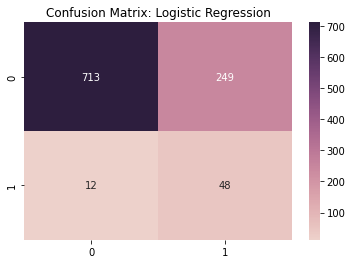

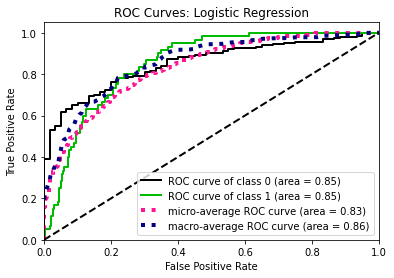

In [ ]:
#log_model_opt = [('Logistic Regression', LogisticRegression(max_iter=1000, random_state=10))]
model_run(log_model_opt)

**Logistic Regression**, `LogisticRegression()`

Previous:
* *Testing Accuracy: 0.7485322896281801*
* *Training Accuracy: 0.7677609643498333*

New:
* *Testing Accuracy:  0.7514677103718199*
* *Training Accuracy:  0.7735316747884072*

***Slight improvements have been made.***

### LinearDiscriminantAnalysis Tuning
[Article](https://machinelearningmastery.com/linear-discriminant-analysis-for-machine-learning/)

<a name="deploy"></a>
# Deployment